In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# find out last date
lastdate = (session.query(Measurement.date).order_by(Measurement.date.desc())).first()
lastdate
#last date is 2017-08-23 so need to check August 23, 2016 through August 23, 2017

last12months = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()
last12months

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last12months_df = pd.DataFrame(last12months, columns=['Date','Precipitation'])

# Sort the dataframe by date
last12months_df = last12months_df.set_index('Date')
last12months_df = last12months_df.sort_values('Date')
last12months_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


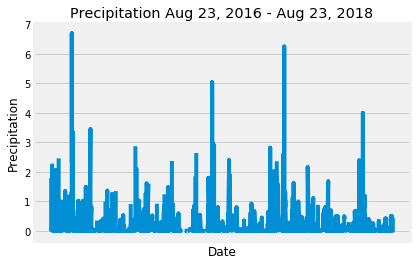

In [14]:
x_values = last12months_df.index.values
y_values = last12months_df['Precipitation'].values

plt.plot(x_values, y_values)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Aug 23, 2016 - Aug 23, 2018')
plt.xticks([])
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.id).count()
total_stations

9

In [59]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity_df = pd.DataFrame(station_activity, columns=['Station','# Rows'])
station_activity_df = station_activity_df.set_index('Station')
station_activity_df.head(1)

,# Rows
Station,
USC00519281,2772


In [60]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

In [57]:
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
lowest_temp

[(54.0)]

In [58]:
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest_temp

[(85.0)]

In [61]:
mean_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
mean_temp

[(71.66378066378067)]

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activity_12months = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.tobs).\
filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23),\
      Measurement.station == 'USC00519281').all()
activity_12months_df = pd.DataFrame(activity_12months, columns = ['Date','TOBS'])
activity_12months_df = activity_12months_df.set_index('Date')
activity_12months_df.head()

,TOBS
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


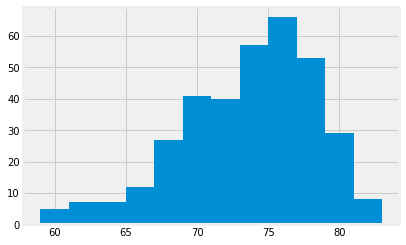

In [98]:
plt.hist(activity_12months_df['TOBS'], bins=12)
plt.show()